# Waving Goodbye to Subsequent COVID-19 Waves
### Using data from the Government of Canada on daily cases and daily vaccinations to model the end of the pandemic in Canada

**Disclaimer**: Please note that this project is just for fun and for my personal learning. Although the data is publicly retrievable, these analyses should __not__ be used to guide real-world decisions. Models use an idealized input and are not adequate representations of human behaviour. 

## Part 1. Data Retrieval
The first thing to do is to retrieve data from the Government of Canada websites

In [1]:
# Import dependencies
import datetime
import missingno as msno
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import urllib

# Display plots inline
%matplotlib inline

In [2]:
# Make a directory to hold the data if it doesn't exist
if not os.path.exists("../data"):
    os.makedirs("../data")

So now we will have to define a function that takes as input a remote URL containing our desired data_source and our output filename.

In [3]:
def download(remote_url: str, local_file: str):
    """Download a file from a remote URL unless the local_file already exists.
    Returns the local_file name."""
    if not os.path.exists(local_file):
        print(f"Retrieving {local_file}...")
        response = urllib.request.urlretrieve(remote_url, local_file)
        return local_file

In [4]:
# Set target datasets to download for our database
# Thankfully, these databases are in .csv format
url_prefix = "https://health-infobase.canada.ca/src/data/covidLive/"
files_list = ['covid19-download.csv', 'covid19-data-dictionary.csv', 'vaccination-coverage-map.csv']

# Get the current time
now = datetime.datetime.utcnow()

# Then download the datasets
for file in files_list:
    if not os.path.exists("../data/" + file):
        download(url_prefix + file, "../data/" + file)
    else:
        # Get the time of modification for the target file
        last_updated = datetime.datetime.utcfromtimestamp(os.path.getctime("../data/" + file))
        
        # If the age of the file is >1 week old,
        # delete the old file and download a new one from the source
        age = now - last_updated

        if age.days > 7:
            print(f"{file} is >1 week old at {age.days} days. Redownloading {file} from source...")
            os.remove("../data/" + file)
            download(url_prefix + file, "../data/" + file)
        else:
            print(f"{file} is <1 week old at {age.days} days.")

covid19-download.csv is <1 week old at 0 days.
covid19-data-dictionary.csv is <1 week old at 0 days.
vaccination-coverage-map.csv is <1 week old at 0 days.


Now that we have our datasets, let's transfer them into a dataframe and see what's inside:

In [5]:
# Read all our data into separate dataframes
data_dict = pd.read_csv('../data/covid19-data-dictionary.csv')
epi_data = pd.read_csv('../data/covid19-download.csv')
vax_data = pd.read_csv('../data/vaccination-coverage-map.csv')

data_dict

,Column Header,Variable Name,Description
0,pruid,Provincial ID,1=Canada \r\n10=Newfoundland and Labrador\r\n1...
1,prname,Province name,Name of P/T (English)
2,prnameFR,Province name,Name of P/T (French)
3,date,Report date,Date reported by P/T
4,numconf,Number of confirmed cases,Number of confirmed cases in each P/T (Canada=...
5,numprob,Number of probable cases,Number of probable cases in each P/T (Canada= ...
6,numdeaths,Number of deaths,Number of deaths in each P/T (Canada= sum of a...
7,numtotal,Total number of cases,Calculated by number of confirmed cases plus n...
8,numtested,Number of individuals tested,"Number of individuals tested in each P/T, as r..."
9,numrecover,Number of recovered cases,Number of recovered cases in each P/T (Canada=...


In [6]:
# Take a look at what's inside one of the dataframes
epi_data.head(10)

,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,1,Canada,Canada,2020-02-08,NaN,7,0.0,0.0,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,35,Ontario,Ontario,2020-02-16,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,59,British Columbia,Colombie-Britannique,2020-02-16,NaN,5,0.0,0.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,1,Canada,Canada,2020-02-16,NaN,8,0.0,0.0,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,35,Ontario,Ontario,2020-02-21,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


It looks like `data_dict` is a dictionary for the column headers for `epi_data`. Let's define them outside here: 

| Column Header | Variable Name | Description | 
| :--- | :--- | :--- |
| **pruid** | Provincial ID | 1=Canada <br> 10=Newfoundland and Labrador <br> 11=Prince Edward Island <br> 12=Nova Scotia <br> 13=New Brunswick <br> 24=Quebec <br> 35=Ontario <br> 46=Manitoba <br> 47=Saskatchewan <br> 48=Alberta <br> 59=British Colombia <br> 60=Yukon <br> 61=Northwest Territories <br> 62=Nunavut <br> 99=Repatriated Travellers |
| **prname** | Province name | Name of P/T (English) |
| **prnameFR** | Province name | Name of P/T (French) |  
| **date** | Report date | Date reported by P/T |
| **numconf** | Number of confirmed cases | Number of confirmed cases in each P/T (Canada= sum of all P/Ts) |
| **numprob** | Number of probable cases | Number of probable cases in each P/T (Canada= sum of all P/Ts) | 
| **numdeaths** | Number of deaths | Number of deaths in each P/T (Canada= sum of all P/Ts) |
| **numtotal** | Total number of cases | Calculated by number of confirmed cases plus number of probable cases (numconf+numprob) |
| **numtested** | Number of individuals tested | Number of individuals tested in each P/T, as reported from the National Microbiology Laboratory |
| **numrecover** | Number of recovered cases | Number of recovered cases in each P/T (Canada=sum of all P/Ts) | 
| **percentrecover** | Percentage of recovered cases | Calculated by the number of recovered cases for a P/T divided by the total number of confirmed cases for that P/T [(numrecover/numtotal) x100] |
| **ratetested** | Testing rate per one million population | Calculated by the number of individuals tested for a P/T divided by the population of that P/T [(numtested/population) x1,000,000] |
| **numtoday** | Number of new cases since last update | Number of total counts from last update subtracted from total counts of current update |
| **percentoday** | Percent change since last update | Calculated by the number of new cases divided by the previous update's total number of cases [(numtoday/numtotal of previous update)x100] |
| **ratetotal** | Case rate per one hundred thousand population | Calculated by the total number of cases for a P/T divided by the population of that P/T[(numtotal/population) x100,000] |

In [7]:
# Describe the rest of the epidemiological data
epi_data.describe()

,pruid,update,numconf,numprob,numdeaths,numtotal,numtested,numtests,numrecover,percentrecover,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
count,9957.000000,4823.000000,9.957000e+03,6312.000000,9838.000000,9.957000e+03,4.905000e+03,9.957000e+03,9.433000e+03,9229.000000,...,9058.000000,9705.000000,9058.000000,9705.000000,9057.000000,9705.000000,9058.000000,9705.000000,9058.000000,9297.000000
mean,39.154765,0.804893,1.073837e+05,1.039924,2356.259809,1.073840e+05,8.376140e+05,2.984524e+06,1.059522e+05,89.197161,...,1.063415,2943.962287,43.515941,43.540031,0.533162,420.554044,6.216636,6.203812,0.076028,5.644903
std,26.270142,0.396324,2.792602e+05,16.599030,5457.587648,2.792602e+05,2.277015e+06,7.585683e+06,2.725709e+05,15.421090,...,1.973587,8390.313386,70.491007,127.333712,1.048157,1198.618620,10.070128,18.198409,0.149714,14.172579
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-49.250000
25%,12.000000,1.000000,1.290000e+02,0.000000,0.000000,1.290000e+02,4.464000e+03,1.228000e+04,1.710000e+02,87.280000,...,0.000000,2.000000,1.610000,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,0.000000
50%,46.000000,1.000000,1.567000e+03,0.000000,32.000000,1.567000e+03,5.729200e+04,2.055910e+05,1.588000e+03,94.150000,...,0.230000,77.000000,11.690000,1.000000,0.100000,11.000000,1.670000,0.000000,0.010000,0.680000
75%,60.000000,1.000000,6.081300e+04,0.000000,1457.250000,6.081300e+04,3.741220e+05,1.384479e+06,5.935400e+04,97.650000,...,1.250000,2195.000000,60.990000,23.000000,0.580000,314.000000,8.710000,3.000000,0.080000,6.530000
max,99.000000,1.000000,2.142310e+06,833.000000,30280.000000,2.142310e+06,1.748336e+07,5.256074e+07,1.878245e+06,100.780000,...,17.400000,196556.000000,877.590000,1236.000000,9.000000,28079.000000,125.370000,177.000000,1.290000,435.130000


In [8]:
# Describe the vaccination coverage data
vax_data.describe()

,pruid,numtotal_atleast1dose,numtotal_partially,numtotal_fully,numtotal_additional,proptotal_atleast1dose,proptotal_partially,proptotal_fully,proptotal_additional,numeligible_atleast1dose,...,num5plus_fully,num5plus_additional,prop5plus_atleast1dose,prop5plus_partially,prop5plus_fully,prop5plus_additional,numweekdelta_atleast1dose,numweekdelta_fully,propweekdelta_atleast1dose,propweekdelta_fully
count,735.000000,7.350000e+02,7.260000e+02,7.210000e+02,1.500000e+01,735.000000,726.000000,721.000000,15.000000,4.060000e+02,...,4.060000e+02,1.500000e+01,406.000000,397.000000,406.000000,15.000000,0.0,0.0,0.0,0.0
mean,34.972789,2.589097e+06,7.449760e+05,1.882980e+06,6.569879e+05,48.465619,12.252039,36.461110,14.965333,3.984892e+06,...,3.263732e+06,6.569803e+05,76.644409,12.655567,63.159655,15.929333,NaN,NaN,NaN,NaN
std,21.677392,5.924624e+06,2.230445e+06,5.053935e+06,9.150085e+05,30.457485,13.975163,31.311762,7.764431,7.306593e+06,...,6.391860e+06,9.149963e+05,7.519782,14.383981,20.202729,8.312161,NaN,NaN,NaN,NaN
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.530000e+03,0.000000,0.000000,0.000000,4.980000,1.779800e+04,...,1.439700e+04,5.530000e+03,50.380000,2.140000,2.880000,5.240000,NaN,NaN,NaN,NaN
25%,12.000000,2.836300e+04,6.150000e+03,1.720000e+04,5.794800e+04,14.975000,3.502500,2.200000,9.990000,1.296988e+05,...,7.610925e+04,5.794800e+04,71.720000,4.840000,58.242500,10.610000,NaN,NaN,NaN,NaN
50%,46.000000,3.885110e+05,6.789000e+04,8.916900e+04,1.864080e+05,62.420000,6.605000,39.710000,13.470000,7.723905e+05,...,6.658195e+05,1.864070e+05,77.450000,6.900000,70.055000,14.320000,NaN,NaN,NaN,NaN
75%,59.000000,1.614376e+06,3.962810e+05,7.886990e+05,8.712380e+05,74.565000,14.322500,68.400000,16.450000,3.943720e+06,...,3.107629e+06,8.712265e+05,81.980000,10.730000,76.950000,17.720000,NaN,NaN,NaN,NaN
max,62.000000,3.128078e+07,1.996081e+07,2.925302e+07,3.021935e+06,92.890000,60.950000,85.720000,31.160000,3.013940e+07,...,2.925087e+07,3.021902e+06,96.510000,63.600000,89.070000,33.300000,NaN,NaN,NaN,NaN


Let's take a look at all the missing data in our dataframes.

<AxesSubplot:>

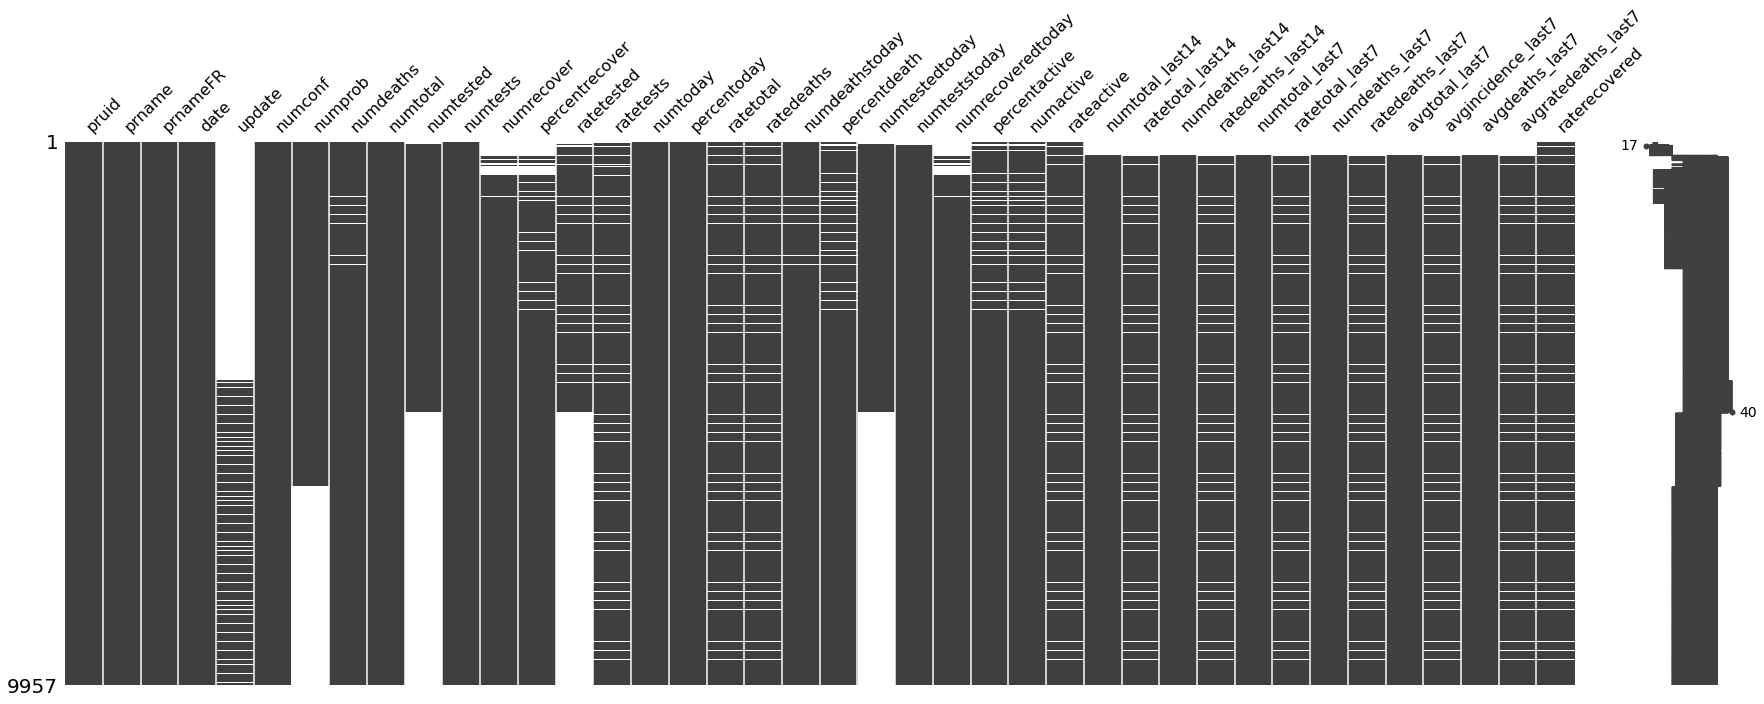

In [9]:
# Plot graphic of missing data for epi_data
msno.matrix(epi_data, figsize=(30, 10))

<AxesSubplot:>

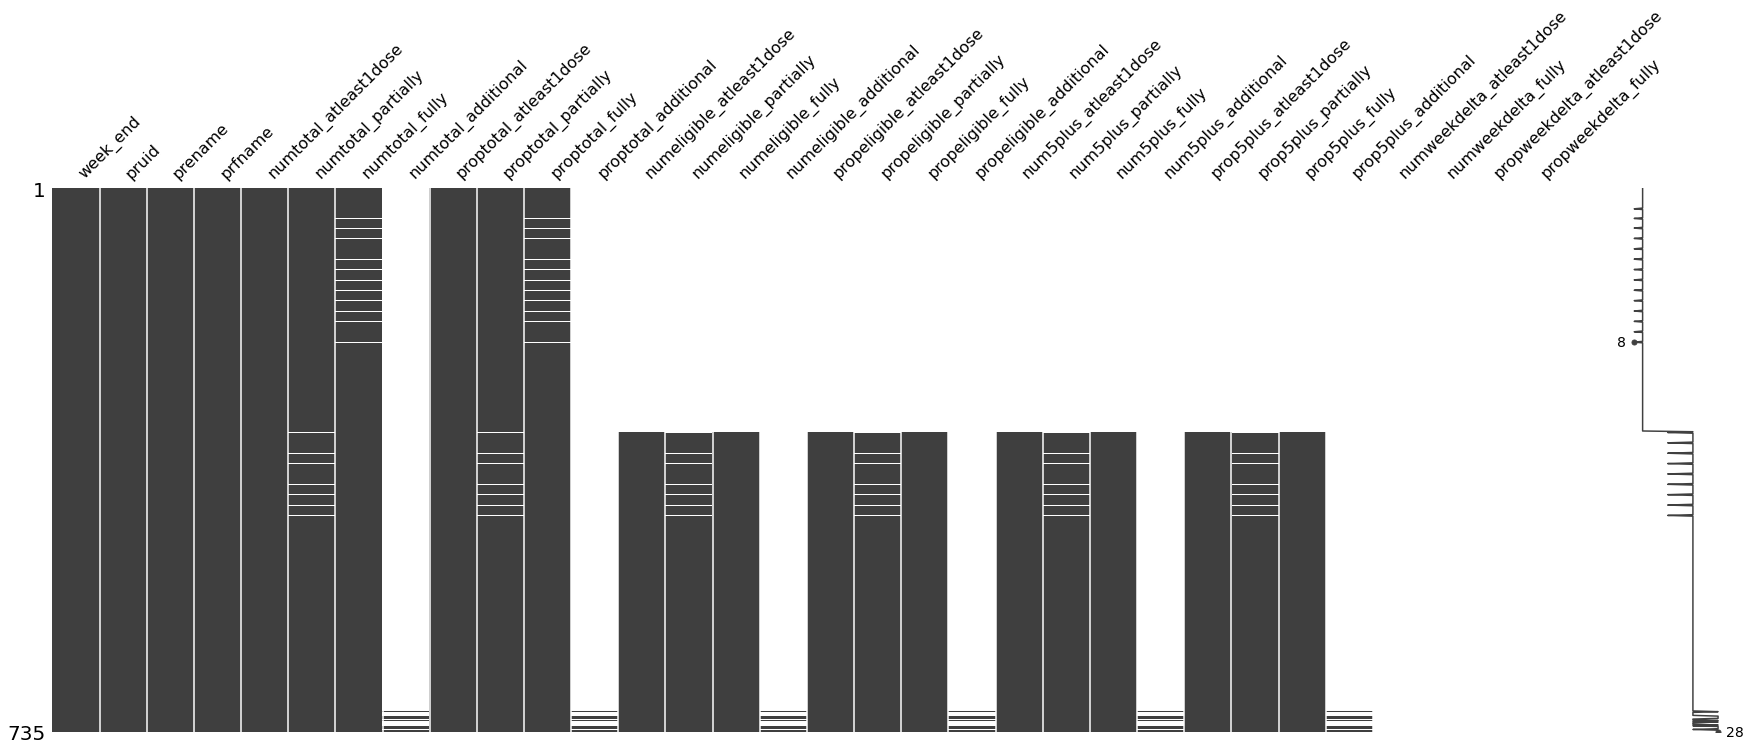

In [10]:
# Plot graphic for missing data for vax_data
msno.matrix(vax_data, figsize=(30, 10))

In [46]:
# Extract provincial IDs into a list
pruid = sorted(epi_data["pruid"].unique())

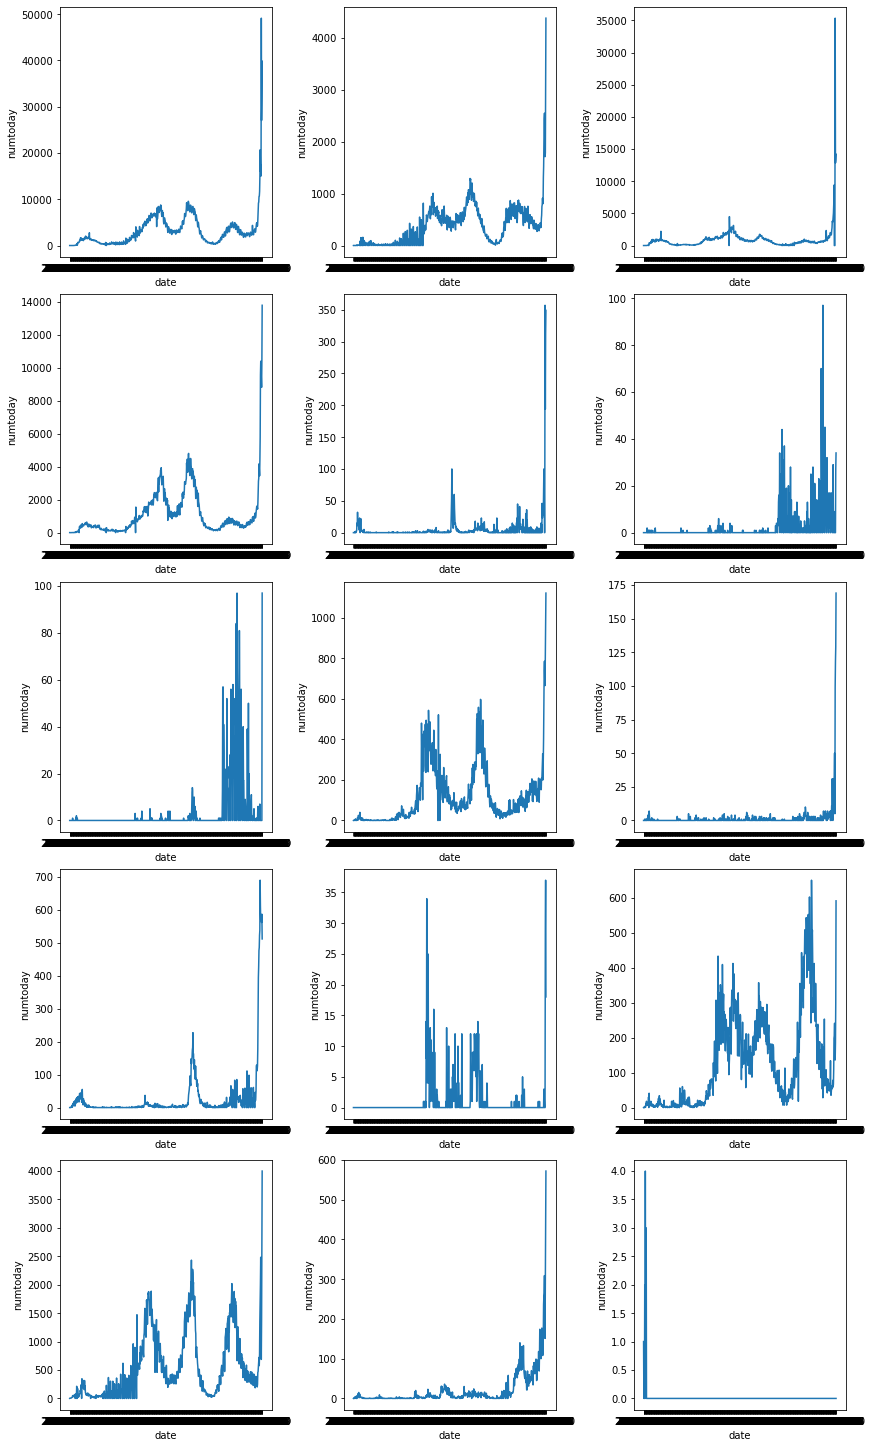

In [47]:
# Generate a subplot structure to display graphs in a 5x3 grid
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(12, 20), constrained_layout=True)

# For each subplot, generate a plot of numtoday cases by date
for i, province in enumerate(pruid):
    # Select subplot by row and column index
    row_index = i % ax.shape[0]
    col_index = i % ax.shape[1]

    # Select the data by province and generate a lineplot 
    sns.lineplot(ax=ax[row_index, col_index], data=epi_data[epi_data["pruid"] == province], x="date", y="numtoday")
    # ax[row_index, col_index].set_title(epi_data[epi_data["pruid"] == province]["prname"].item())